In [26]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

#mean squared error, mean absolute error, and coefficient of determination
import lcpfn.lcpfn as lcpfn

path_test = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/test_curves.pkl'
df_test = pd.read_pickle(path_test)

path_all = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/all_curves_preprocessed.pkl'
df_all = pd.read_pickle(path_all)

# model_name = '/mnt/c/Users/prath/PycharmProjects/rp/Data/model_lcdb_2.pt'
model_name = None
if model_name is None:
    model = lcpfn.LCPFN()
else:
    model = lcpfn.LCPFN(model_name=model_name)
print(model_name)

None


In [27]:
#Variables
cut_off = 30

In [28]:
def get_validation_curve(i:int):
    """Retrieve the validation curve for a given model and dataset."""
    row = df_all.iloc[i]
    openlid = row['openmlid']
    learner = row['learner']
    anchors = row['anchors']
    means = row['means']
    std = row['std']
    return anchors, means, std, openlid, learner

def get_closest_index(lst, target):
    return min(range(len(lst)), key=lambda i: abs(lst[i] - target))

def get_common_data(cutoff, extend, anchors, means, ):

    means = np.array(means)
    anchors = np.array(anchors)
    anchors = ((anchors - np.min(anchors)) / (np.max(anchors) - np.min(anchors))) * 100

    cutoff_index = get_closest_index(anchors, cutoff)
    curve = np.array(means[:cutoff_index])
    anchors = anchors.astype(int)

    add_anchor = np.arange(anchors[-1], extend, 10)
    a = np.concatenate((anchors, add_anchor))
    x = torch.from_numpy(a).unsqueeze(1)
    y = torch.from_numpy(curve).float().unsqueeze(1)

    return x, y, anchors, means, cutoff_index

def get_mse(model, anchors, means, cutoff=10, extend=100, plot=False):
    x, y, anchors, means, cutoff_index = get_common_data(cutoff, extend, anchors, means, )

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:], qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchors, means, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    mse_lcfpn = np.mean((predictions[:len(anchors) - cutoff_index, 1] - means[cutoff_index:]) ** 2)
    mse_l1 = np.mean((predictions[:len(anchors)-cutoff_index, 1] - means[-1])**2)
    #TODO mse_mff4 = get the curve fitting code form the supervisors
    return mse_lcfpn#, mse_l1 #, mse_mff4


def get_mae(model, anchors, means ,cutoff=10, extend=100, plot=False):
    x, y, anchors, means, cutoff_index = get_common_data(cutoff, extend, anchors, means,)

    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:], qs=[0.05, 0.5, 0.95])

    if plot:
        plot_it(anchors, means, predictions, cutoff_index, x)

    predictions = predictions.detach().numpy()
    return np.mean(np.abs(predictions[:len(anchors) - cutoff_index, 1] - means[cutoff_index:]))


def plot_it(anchors, means, predictions, cutoff_index, x):
    plt.plot(anchors, means, "*", label="target")
    plt.plot(anchors, means, label="target")
    plt.plot(x[cutoff_index:], predictions[:, 1], "r*", label="Extrapolation by PFN")
    plt.fill_between(
        x[cutoff_index:].flatten(), predictions[:, 0], predictions[:, 2], color="blue", alpha=0.2, label="CI of 90%"
    )
    plt.vlines(x[cutoff_index], 0, 1, linewidth=0.5, color="k", label="cutoff")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.savefig("/mnt/c/Users/prath/PycharmProjects/rp/Data/extrapolation.png")
    plt.show()




44 SVC_poly


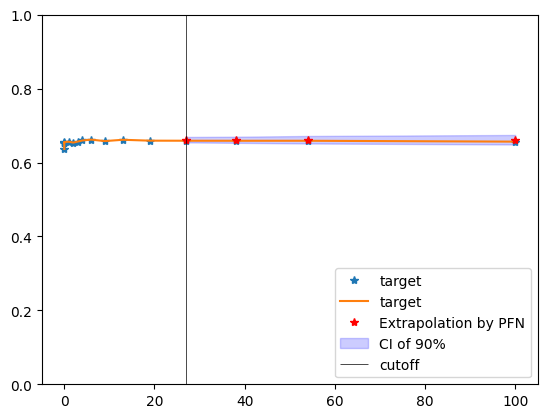

1.1317016583838585e-05
0.003217058407783552


In [29]:
anchors, means, std, openlid, learner = get_validation_curve(1)
print(openlid, learner)
print(get_mse(model, anchors, means, cutoff=cut_off, plot=True))
print(get_mae(model, anchors, means, cutoff=cut_off))

In [30]:
performance  = []
performance_lable  = []

for i in range(100):
    print(i+1, end='\r')
    anchors, means, std, openlid, learner = get_validation_curve()
    performance.append([get_mse(model, anchors, means), get_mae(model, anchors, means)])
    performance_lable.append(str(int(openlid)) + '_' + learner)

performance  = np.array(performance)

TypeError: get_validation_curve() missing 1 required positional argument: 'i'

In [ ]:
# Print the results in a clear format
df = pd.DataFrame(performance, columns=['mse', 'mae'])
print(df.describe())